In [52]:
import jieba
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy import io,sparse
import json
import joblib
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.decomposition import PCA

In [53]:
def logtime(func):
    """
    函数目的：测量函数运行时间 
    Parameter:
        func - 被测量的函数
    Return:
        wrapper - 被装饰之后的函数
    """
    def wrapper(*args,**kwargs):
        start = time.time()
        result = func(*args,**kwargs)
        end = time.time()
        print("完成函数{name}, 运行时间 {totaltime:.3f}s".format(name=func.__name__,totaltime=end-start))
        start = time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(start))
        end = time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(end))
        print("开始时间 : %s \n结束时间 : %s "%(start,end))
        return result
    return wrapper

In [54]:
def load_data_from_file(content_path,label_path):
    content = io.mmread(content_path)
    with open(label_path, 'r') as f:
        label = json.load(f)
    return content,label

In [55]:
def split_data(content,label):
    train_content,test_content,train_label,test_label = train_test_split(content,label,test_size=0.2)
    return train_content,test_content,train_label,test_label

In [56]:
@logtime
def dimensionality_reduction(content):
        n_components = 1000
        pca = PCA(n_components=n_components, svd_solver='auto')
        pca.fit(content)
        content = sparse.csr_matrix(pca.transform(content))
        return content

In [57]:
@logtime
def clf_train(clf,train_content,train_label):
    return clf.fit(train_content.toarray(),train_label)

In [58]:
def train_svm(train_content,train_label):
    """
    函数说明：训练SVM分类器
    Parameter:
        train_content - 训练数据
        train_label - 训练标签
    Return:
        classifier.fit(vector,label) - 训练好的分类器
    Modify:
        2017-12-22
    """
    kernals = ["linear","rbf"]
    clfs = []
    for kernel in kernals:
       
        clf = svm.SVC(kernel=kernel)
        clf = clf_train(clf,train_content,train_label)
        clfs.append(clf)
    return clfs

In [59]:
def train_bayes(train_content,train_label):
    """
    函数说明：训练贝叶斯分类器
    Parameter:
        train_content - 训练数据
        train_label - 训练标签
    Return:
        classifier.fit(vector,label) - 训练好的分类器
    Modify:
        2017-12-22
    
    """
    bayes = [ GaussianNB(),MultinomialNB(),BernoulliNB()]
    clfs = []
    for baye in bayes:
        clf = clf_train(baye,train_content,train_label)
        clfs.append(clf)
    return clfs

In [60]:
@logtime
def clf_pred(clf,test_content,test_label):
    pred=clf.predict(test_content.toarray())
    score = elevate_result(pred,test_label)
    return score

In [61]:
def elevate_result(label,pred):
    """
    函数说明: 对分类器预测的结果进行评估，包括accurancy,precision,recall,F-score
    Parameter:
        label - 真实值
        pred - 预测值
    Return:
        None
    Modify:
        2017-12-22
    """
    con_mat = metrics.confusion_matrix(label,pred)
    TP = con_mat[1,1]
    TN = con_mat[0,0]
    FP = con_mat[0,1]
    FN = con_mat[1,0]
    
    accurancy = (TP+TN)/(TP+TN+FN+FP)
    precison = TP/(TP+FP) #精确率反应误报情况
    recall = TP/(TP+FN) # 召回率反应漏报情况
    beta = 1
    F_score = (1+pow(beta,2))*precison*recall/(pow(beta,2)*precison+recall)
    
    print("TP:",TP)
    print("TN:",TN)
    print("FP:",FP)
    print("FN:",FN) 
    print("accurancy: %s \nprecison: %s \nrecall: %s \nF-score: %s" % (accurancy,precison,recall,F_score))
    
    return [accurancy,precison,recall,F_score]


In [62]:
# from matplotlib.ticker import FormatStrFormatter
def plot_result(scores,sample_num):
    scorename = ["accurancy","precision","recall","F_score"]
    labels = ["SVM-linear","SVM-rbf","GaussianNB","MultinomialNB","BernoulliNB"]
#     labels = ["SVM-linear","SVM-rbf"]
    fig,ax = plt.subplots(figsize=(16,10))
    
    x = np.arange(len(scorename))
    total_width, n = 0.8,5     # 有多少个类型，只需更改n即可
    width = total_width / n
    x = x - (total_width - width) / 2
    
    for index,score in enumerate(scores):
        rects=ax.bar(x+index*width,score,alpha=0.8,label=labels[index],width=width)
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width() / 2., 1.005 * height,
                    f'{height:.3g}', ha='center', va='bottom')
        
    ax.set_ylim(ymax=1.2)     
    # ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    # ax.set_yticks(np.arange(0,1.2,0.2))
    ax.set_yticklabels(['%.1f' % i for i in np.arange(0,1.2,0.2)], fontsize=15)
    # ax.set_yticklabels(np.arange(0,1.2,0.2),fontsize=15)
    ax.set_xlim(xmax=len(scorename)+0.5)
    ax.set_xticks(range(len(scorename)))
    ax.set_xticklabels(scorename,fontsize=15)
    plt.legend(loc='lower right',fontsize=15)
    plt.title("The result of "+sample_num,fontsize=20)
    plt.savefig("../result/"+sample_num+"_result.jpg")
    plt.show()

In [63]:
def main(sample_num):
    content_path = "../data/"+sample_num+"_content_vector.mtx"
    label_path =  "../data/"+sample_num+"_label_vector.json"
    
    content,label=load_data_from_file(content_path,label_path)
#     content = dimensionality_reduction(content.todense())
    train_content,test_content,train_label,test_label = split_data(content,label)
    
    scores = []
    
    svms = train_svm(train_content,train_label)
    for clf in svms:   
        score = clf_pred(clf,test_content,test_label)
        scores.append(score)
        
    bayes = train_bayes(train_content,train_label)
    for clf in bayes:   
        score = clf_pred(clf,test_content,test_label)
        scores.append(score)
    plot_result(scores,sample_num)

完成函数clf_train, 运行时间 34.607s
开始时间 : 2024-03-20 09:12:55 
结束时间 : 2024-03-20 09:13:30 
完成函数clf_train, 运行时间 52.965s
开始时间 : 2024-03-20 09:13:30 
结束时间 : 2024-03-20 09:14:23 
TP: 210
TN: 1781
FP: 9
FN: 0
accurancy: 0.9955 
precison: 0.958904109589041 
recall: 1.0 
F-score: 0.9790209790209791
完成函数clf_pred, 运行时间 4.488s
开始时间 : 2024-03-20 09:14:23 
结束时间 : 2024-03-20 09:14:27 
TP: 207
TN: 1776
FP: 12
FN: 5
accurancy: 0.9915 
precison: 0.9452054794520548 
recall: 0.9764150943396226 
F-score: 0.9605568445475638
完成函数clf_pred, 运行时间 40.562s
开始时间 : 2024-03-20 09:14:27 
结束时间 : 2024-03-20 09:15:08 
完成函数clf_train, 运行时间 0.845s
开始时间 : 2024-03-20 09:15:08 
结束时间 : 2024-03-20 09:15:09 
完成函数clf_train, 运行时间 0.951s
开始时间 : 2024-03-20 09:15:09 
结束时间 : 2024-03-20 09:15:10 
完成函数clf_train, 运行时间 0.858s
开始时间 : 2024-03-20 09:15:10 
结束时间 : 2024-03-20 09:15:10 
TP: 215
TN: 1638
FP: 4
FN: 143
accurancy: 0.9265 
precison: 0.9817351598173516 
recall: 0.6005586592178771 
F-score: 0.7452339688041595
完成函数clf_pred, 运行时间 0.203s
开始时

/tmp/ipykernel_662476/932863212.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['%.1f' % i for i in np.arange(0,1.2,0.2)], fontsize=15)


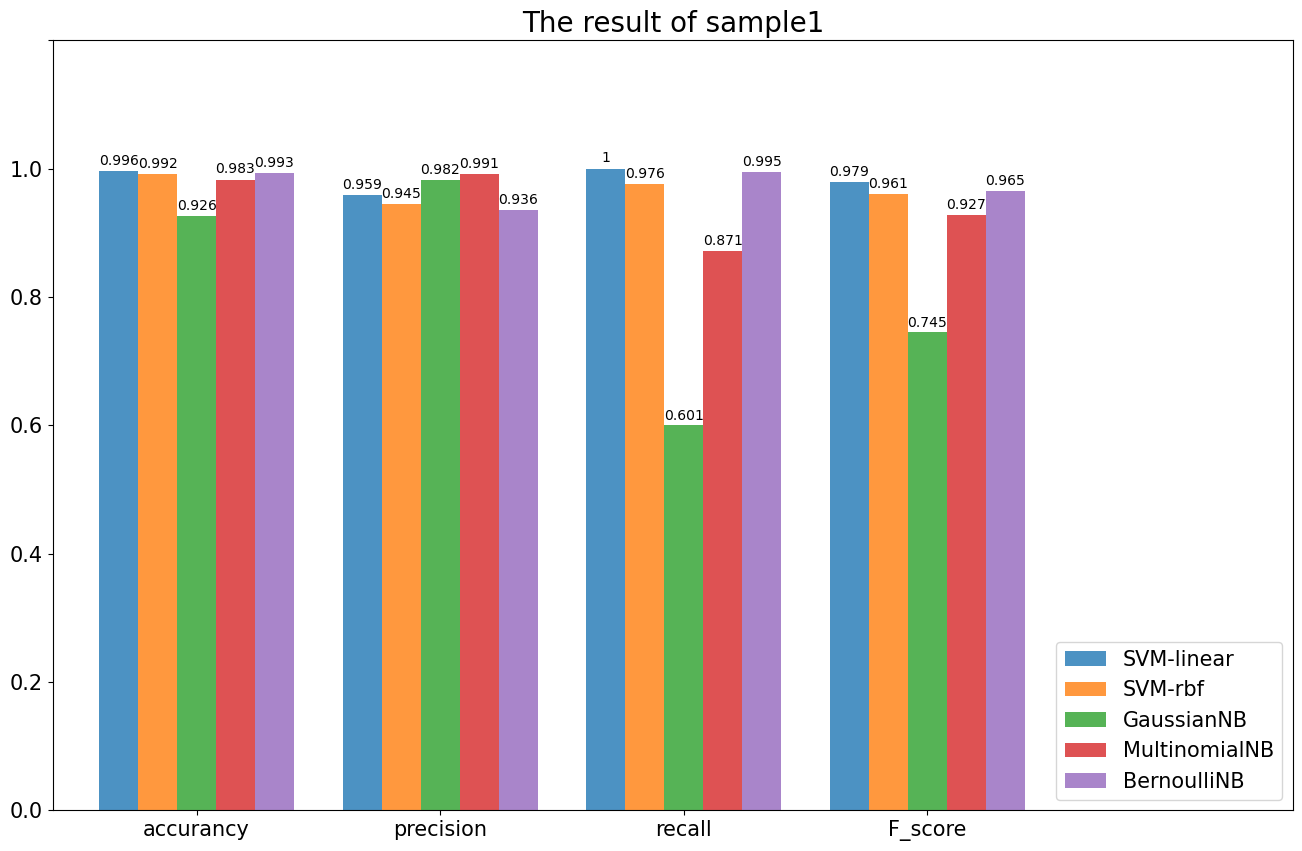

完成函数clf_train, 运行时间 68.619s
开始时间 : 2024-03-20 09:15:11 
结束时间 : 2024-03-20 09:16:20 
完成函数clf_train, 运行时间 133.996s
开始时间 : 2024-03-20 09:16:20 
结束时间 : 2024-03-20 09:18:34 
TP: 283
TN: 2711
FP: 6
FN: 0
accurancy: 0.998 
precison: 0.9792387543252595 
recall: 1.0 
F-score: 0.9895104895104895
完成函数clf_pred, 运行时间 6.179s
开始时间 : 2024-03-20 09:18:34 
结束时间 : 2024-03-20 09:18:40 
TP: 278
TN: 2706
FP: 11
FN: 5
accurancy: 0.9946666666666667 
precison: 0.9619377162629758 
recall: 0.9823321554770318 
F-score: 0.972027972027972
完成函数clf_pred, 运行时间 123.082s
开始时间 : 2024-03-20 09:18:40 
结束时间 : 2024-03-20 09:20:43 
完成函数clf_train, 运行时间 1.743s
开始时间 : 2024-03-20 09:20:43 
结束时间 : 2024-03-20 09:20:45 
完成函数clf_train, 运行时间 1.793s
开始时间 : 2024-03-20 09:20:45 
结束时间 : 2024-03-20 09:20:47 
完成函数clf_train, 运行时间 1.688s
开始时间 : 2024-03-20 09:20:47 
结束时间 : 2024-03-20 09:20:49 
TP: 287
TN: 2486
FP: 2
FN: 225
accurancy: 0.9243333333333333 
precison: 0.9930795847750865 
recall: 0.560546875 
F-score: 0.7166042446941324
完成函数clf_pre

/tmp/ipykernel_662476/932863212.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['%.1f' % i for i in np.arange(0,1.2,0.2)], fontsize=15)


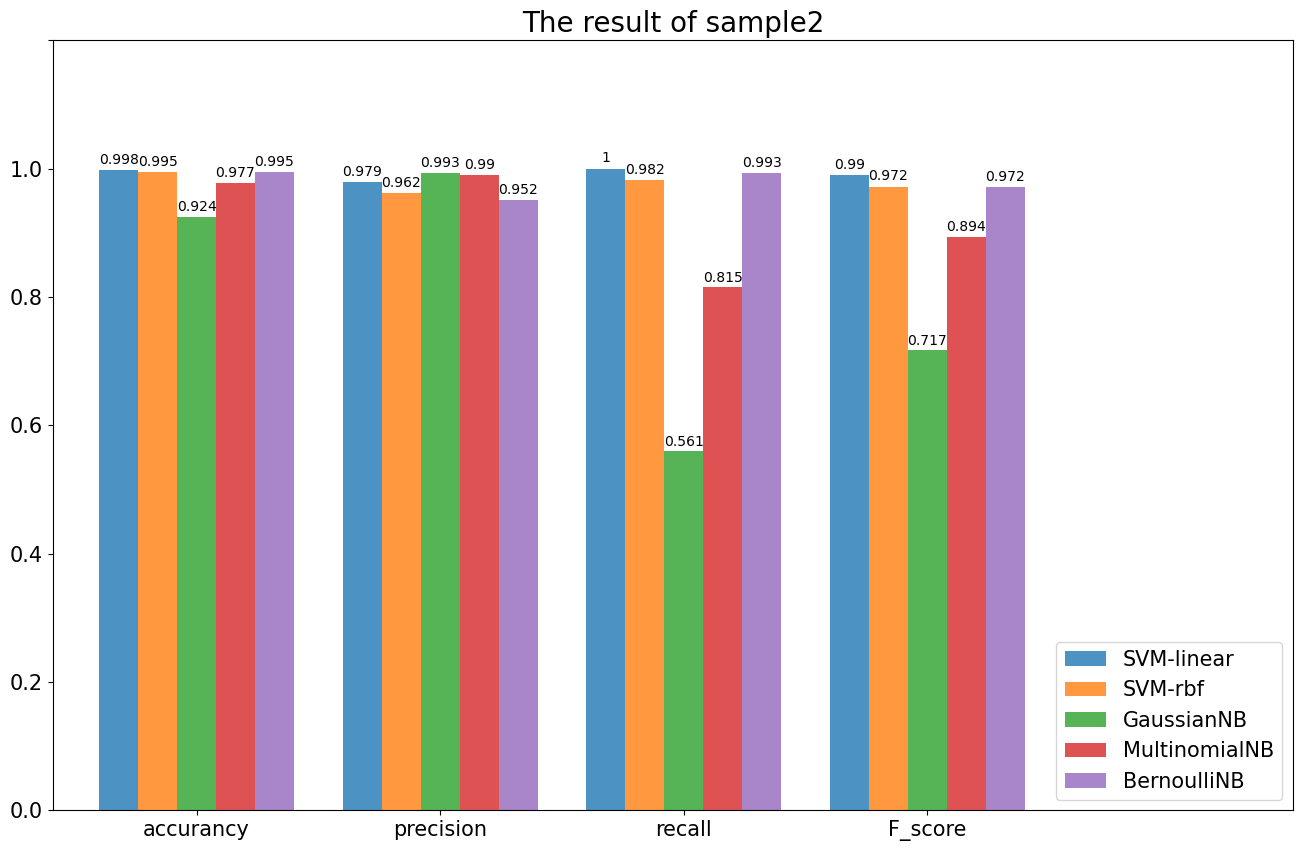

完成函数clf_train, 运行时间 98.192s
开始时间 : 2024-03-20 09:20:50 
结束时间 : 2024-03-20 09:22:28 
完成函数clf_train, 运行时间 145.299s
开始时间 : 2024-03-20 09:22:28 
结束时间 : 2024-03-20 09:24:53 
TP: 399
TN: 3588
FP: 12
FN: 1
accurancy: 0.99675 
precison: 0.9708029197080292 
recall: 0.9975 
F-score: 0.9839704069050556
完成函数clf_pred, 运行时间 10.691s
开始时间 : 2024-03-20 09:24:53 
结束时间 : 2024-03-20 09:25:04 
TP: 388
TN: 3589
FP: 23
FN: 0
accurancy: 0.99425 
precison: 0.9440389294403893 
recall: 1.0 
F-score: 0.9712140175219024
完成函数clf_pred, 运行时间 151.635s
开始时间 : 2024-03-20 09:25:04 
结束时间 : 2024-03-20 09:27:36 
完成函数clf_train, 运行时间 2.892s
开始时间 : 2024-03-20 09:27:36 
结束时间 : 2024-03-20 09:27:39 
完成函数clf_train, 运行时间 2.860s
开始时间 : 2024-03-20 09:27:39 
结束时间 : 2024-03-20 09:27:42 
完成函数clf_train, 运行时间 2.850s
开始时间 : 2024-03-20 09:27:42 
结束时间 : 2024-03-20 09:27:44 
TP: 407
TN: 3308
FP: 4
FN: 281
accurancy: 0.92875 
precison: 0.9902676399026764 
recall: 0.5915697674418605 
F-score: 0.7406733393994541
完成函数clf_pred, 运行时间 0.683s
开始时间 : 

/tmp/ipykernel_662476/932863212.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['%.1f' % i for i in np.arange(0,1.2,0.2)], fontsize=15)


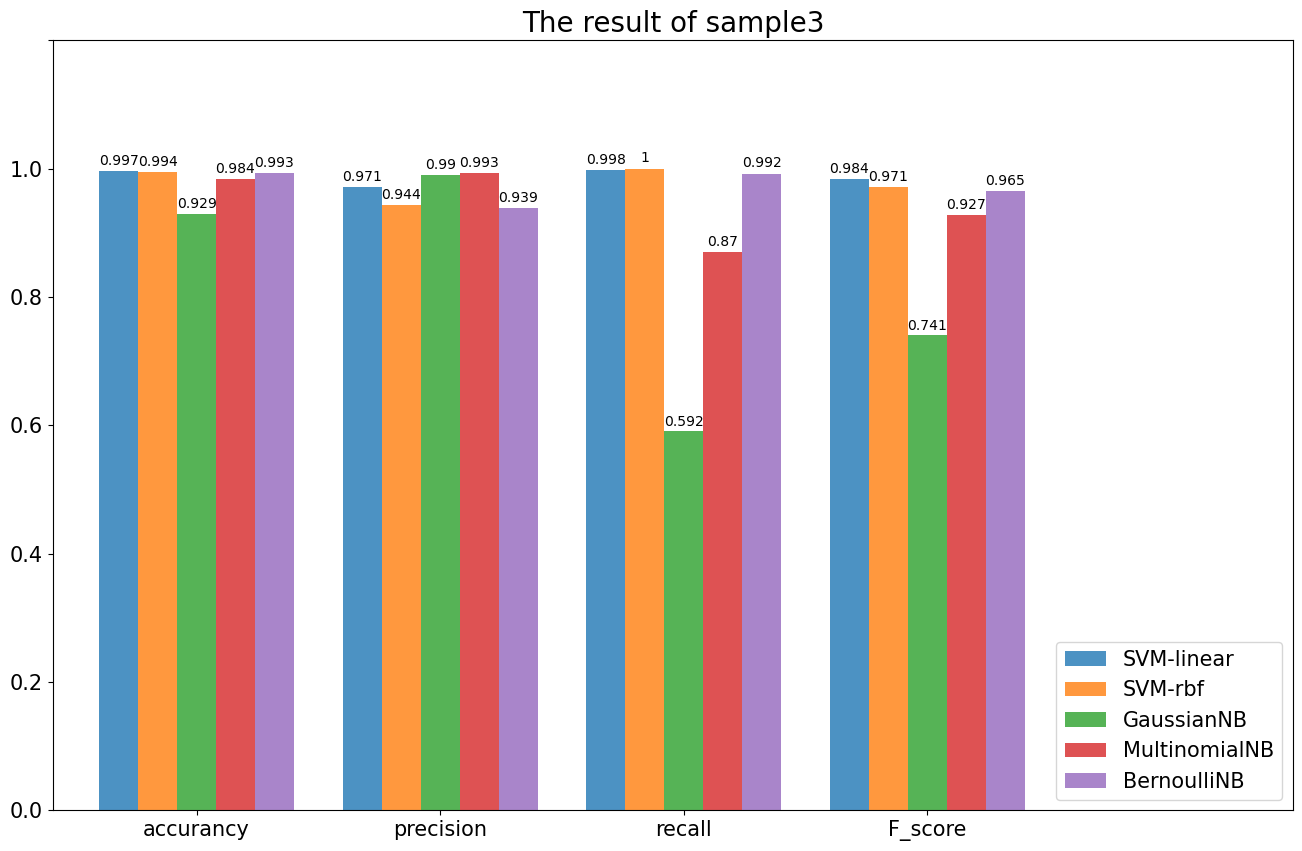

In [64]:
if __name__ == "__main__":
#     pass
    sample_list=['sample1','sample2','sample3']
    for sample in sample_list:
        main(sample)